In [2]:
# Allows code to be hidden, for more polished viewing

from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
import pandas as pd
from __future__ import print_function
from ipywidgets import *
import ipywidgets as widgets

In [4]:
%matplotlib inline

In [5]:
# REE order for plots
elements = array([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14])
el_names = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Yb']
chon = array([0.2347, 0.6032, 0.0891, 0.4524, 0.1471, 0.056, 0.1966, 0.0363, 0.2427, 0.0566, 0.1589, 0.1625])

In [6]:
# Partition coefficients

# ol, opx from JMW's Liang REE text file
# cpx updated to be Sun and Liang 2012
# sp from Kelemen 2003

# D_ol/liq, D_opx/liq, D_cpx/liq, D_sp/liq
partition_coeffs = array(
[[0.0000023,0.00074,0.0550,0.000600],
[0.0000073,0.0016,0.0876,0.000600],
[0.000021,0.0032,0.1318,0.0006],
[0.000058,0.0060,0.1878,0.000600],
[0.00029,0.0158,0.3083,0.001000],
[0.00055,0.0227,0.3638,0.001000],
[0.0010,0.0315,0.4169,0.0006],
[0.0017,0.0422,0.4645,0.0006],
[0.0029,0.0549,0.5034,0.002000],
[0.0045,0.0680,0.5294,0.0023],
[0.0066,0.0808,0.5437,0.003000],
[0.0121,0.1036,0.5453,0.005000]])

In [7]:
# Pattern to match

In [8]:
# Melts to add

#REEs, un-normalized
SWIR_Oblique_basalt = array([8.10,20.84,2.89,14.44,3.97,1.36,4.95,0.81,5.25,1.10,3.16,2.93]);

In [9]:
# Load file with Fractional Melting Output, from reemodel_v5.m
xl = pd.ExcelFile('FractionalMelting.xlsx')

# Load sheet as numpy array
REE_data = xl.parse('Sheet1').as_matrix()

# Variables from input file
F = REE_data[:,0] # degree of melting
modes = REE_data[:,1:5] # modal ol,opx,cp,sp ( modes normalized to 1)
REEs = REE_data[:,5:18] # bulk REEs, normalized to chrondrite

In [10]:
# Crystallization modes for the crystallizing melt
xtal_modes = array([0.7, 0, 0.3, 0,]) #ol opx cpx sp

# Melt fractions of interest
melt_F1 = arange(0,0.000001,0.0000001) # 0% to 0.0001%; 10 steps
melt_F2 = arange(0.000001,0.00001,0.000001) # 0.0001% to 0.001%; 10 steps
melt_F3 = arange(0.00001,0.0001,0.00001) # 0.001% to 0.01%; 10 steps
melt_F4 = arange(0.0001,0.001,0.0001) # 0.01% to 0.1%; 10 steps
melt_F5 = arange(0.001,0.01,0.001) # 0.1% to 1%; 10 steps
melt_F6 = arange(0.01,0.1,0.01) # 1% to 10%; 10 steps
melt_F7 = arange(0.1,1,0.1) # 10% to 100%; 10 steps
melt_F = np,concatenate((melt_F1,melt_F2,melt_F3,melt_F4,melt_F5,melt_F6,melt_F7),axis=0)

# Melt addition modeling

## Adding melt into a peridotite residue

For this melt addition model, an initial peridotite residue of DMM composition first undergoes fractional melting, followed by addition of a percentage of a specific melt to the system. The melt is then assumed to crystallize into this system. The initial phases contained within the residue equilibrate their trace elements with the added material such that each mineral has a single composition and partition coefficients are internally consistent between phases, according to the equations:

$$C_{i}^{bulk} = (1-m)C_{i}^{bulk,residue}+mC_{i}^{bulk,melt}$$
$$X_{j}=(1-m)X_{j}^{residue}+mX_{j}^{crystallized\_melt}$$
$$C_{i}^{cpx}=\frac{(D_{i}^{cpx/melt}*C_{i}^{bulk})}{(\sum_{j} D_{i}^{j/melt}X_{j})}$$



<function __main__.REE_plot>

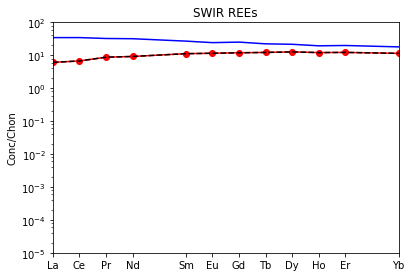

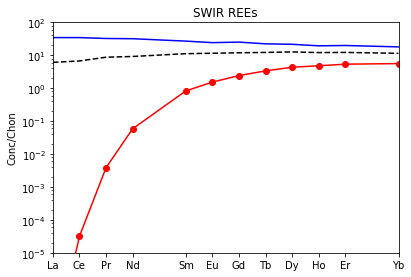

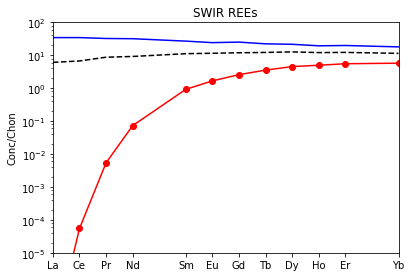

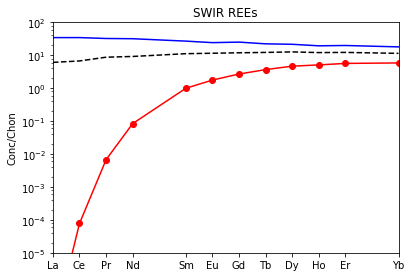

In [11]:
def REE_plot(F,m):
    
    index = np.int(F*10)
    
    DMM = REEs[0,:]*chon
    
    init_residue = REEs[index]*chon
    added_melt = SWIR_Oblique_basalt
    
    # calculate bulk REEs for solid+melt
    bulk = init_residue*(1-m) + added_melt*m
    
    # calculate new modes for solid+melt
    new_modes = modes[index]*(1-m) + xtal_modes*m

    # calculate cpx for solid-melt hybrid from bulk
    cpx = zeros(len(elements))
    cpx_0 = zeros(len(elements))
    for k in range(len(elements)):
        cpx[k] = partition_coeffs[k,2]*bulk[k]/sum(partition_coeffs[k,:]*new_modes)
        cpx_0[k] = partition_coeffs[k,2]*DMM[k]/sum(partition_coeffs[k,:]*modes[0,:])

    cpx_norm = cpx/chon
    cpx_0_norm = cpx_0/chon
    
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
    
    axes.plot(elements,cpx_norm,'r',marker='o')
    axes.plot(elements, cpx_0_norm, 'k--')
    axes.plot(elements, SWIR_Oblique_basalt/chon,'b-')
    
    axes.set_yscale('log')   
    axes.set_ylim([10e-6, 10e1])
    axes.set_xlim([1, 14])
    axes.set_xticks(elements)
    axes.set_xticklabels(el_names, fontsize=10)
    axes.set_yticks(logspace(-5,2,8))
    axes.set_ylabel('Conc/Chon')
    axes.set_title('SWIR REEs')

interact(REE_plot,
         F=FloatSlider(min=0, max=18, step=0.1, continuous_update=False,readout=True,readout_format='.1f',disabled=False), 
         m=FloatSlider(min=0.000, max=0.010, step=0.001, continuous_update=False,readout=True,readout_format='.3f',disabled=False))


test2